##  Comunicados de Política Monetaria
## Parte 2.

Índice:  
$\textbf{1. Obtenemos URLs de anuncios de BANXICO}$  
$\textbf{2. Descargamos los archivos de anuncios de BANXICO}$  
$\textbf{3. Leemos los archivos de anuncios de BANXICO}$  
$\textbf{4. Limpiamos el texto del contenido de los anuncios de BANXICO}$  
$\textbf{5. Comenzamos con la construcción del modelo a través de Naives Bayes}$  
$\textbf{6. Performance del algoritmo}$  

$\textbf{1. Obtenemos URLs de anuncios de BANXICO}$

In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
import requests
import textract
import nltk
from nltk.corpus import stopwords
from itertools import compress
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from multiprocessing.pool import ThreadPool
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\migro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\migro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#URL de anuncios BANXICO
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")

In [3]:
#Imprimimos la URL de extracción de información.
print(url)

https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html


In [4]:
#Generamos sesión, la función nos permite hacer llamadas al servidor y acceso al html.
with HTMLSession() as sess:
    r = sess.get(url)

#Identificamos en el tag 'tr' las URLs que nos ayudarán a extraer las publicaciones
pmonetarias = r.html.find("tr")
print("Número de anuncios: "+ str(len(pmonetarias)))

Número de anuncios: 183


In [5]:
#Definimos una función para extrae la información escencial de cada publicación
def extrae_info_pub(publicaciones):
    """
    Función que extrae la información de las publicaciones
    desde la página:
    https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html
    """
    #tag donde esta la fecha
    qFecha = "td[class='bmdateview']"
    #tag donde esta el resumen
    qResumen = "td[class='bmtextview']"
    #tag donde esta la URL
    qUrl= "a"
    #formato de fecha
    fmt = "%d/%m/%y"
    
    ele_fecha = datetime.strptime(publicaciones.find(qFecha, first=True).text, fmt)
    ele_resumen = publicaciones.find(qResumen, first=True).text
    ele_href = publicaciones.find(qUrl, first=True).attrs["href"]
    ele_url = "https://www.banxico.org.mx"+ ele_href
    #Creamos una nueva columna "category" que extraiga del texto respecto a la tasa
    ele_cat=str(re.findall("(?:mantiene|incrementa|disminuye)", ele_resumen)).replace("[", "").replace("]", "").replace("'","")
    #Creamos variable númerica basado en la categoría
    if ele_cat=='disminuye':
        ele_res=-1
    elif ele_cat=='mantiene':
        ele_res=0
    else:
        ele_res=1
    
    return {
        "date": ele_fecha,
        "text": ele_resumen,
        "url": ele_url,
        "path": "./archivos_banxico/"+str(ele_fecha).split(" ")[0].replace("-", "")+"_"+ele_cat+".pdf",
        "category": ele_cat,
        "respuesta": ele_res
    }

In [6]:
#lista vacia para guardar la información de cada publicación
pub_list = []
#loop para extraer la información de cada publicación
for pub in pmonetarias:
    info =extrae_info_pub(pub)
    pub_list.append(info)  
#Filro fecha
fecha_filtro = datetime.strptime('2008-02-14', "%Y-%m-%d")
#número totalde publicaciones en la lista
n=len(pub_list)
#Lista filrada
pub_list=list(compress(pub_list, [pub_list[k]['date']>fecha_filtro for k in range(0,n)]))  
#Guardamos la lista con información en un dataframe e indexamos con la variable 'date'
pub_df=pd.DataFrame(pub_list).set_index("date")
#últimos reistros del DF
pub_df.tail(5)

,text,url,path,category,respuesta
date,,,,,
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20080620_incrementa.pdf,incrementa,1
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20080516_mantiene.pdf,mantiene,0
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20080418_mantiene.pdf,mantiene,0
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20080314_mantiene.pdf,mantiene,0
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20080215_mantiene.pdf,mantiene,0


In [7]:
#primeros resgistros
pub_df.head(5)

,text,url,path,category,respuesta
date,,,,,
2019-12-19,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20191219_disminuye.pdf,disminuye,-1
2019-11-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20191114_disminuye.pdf,disminuye,-1
2019-09-26,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20190926_disminuye.pdf,disminuye,-1
2019-08-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20190815_disminuye.pdf,disminuye,-1
2019-06-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,./archivos_banxico/20190627_mantiene.pdf,mantiene,0


In [8]:
#Publicaciones filtradas
print("Número de anuncios filtrados: "+ str(pub_df.shape[0]))

Número de anuncios filtrados: 105


$\textbf{2. Descargamos los archivos de anuncios de BANXICO}$

In [9]:
#Definimos una función descaga y guarda los PDFs
def url_descarga(df):
        """
    Función que descaga y guarda los PDFs
    de la página:
    https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html
    """
    #Ruta donde se guarda el archivo y url de descarga
        r = requests.get(df['url'], stream = True)
    #Loop para guardar archivos
        with open(df['path'], 'wb') as f:
            for ch in r:
                f.write(ch)

In [10]:
#creamos directorio para guardar archivos
os.mkdir("./archivos_banxico/")
#descargamos y guardamos los pdfs en multitarea
ThreadPool(9).imap_unordered(url_descarga, pub_list)

$\textbf{3. Leemos los archivos de anuncios de BANXICO}$

In [11]:
#lsta de documentos, el nombre es la fecha
lista_doc=os.listdir('./archivos_banxico/')
#ceamos lista vacía para la inforación de texto de cada anuncio
lista_text=[]
#list comprehension para extraer el texto de cada documento
[lista_text.append(textract.process(f"./archivos_banxico/{doc}", method='pdftotext', encoding='UTF-8').decode("utf-8")) for doc in lista_doc]
#número de publicaciones en la lista
n=len(lista_text)
#último anuncio en la lista
print(lista_text[n-2])

14 de noviembre de 2019
Comunicado de Prensa
Anuncio de Política Monetaria
La Junta de Gobierno del Banco de México ha decidido disminuir en 25 puntos base el objetivo
para la Tasa de Interés Interbancaria a un día a un nivel de 7.50%.
Durante el tercer trimestre del año continuó la desaceleración de la economía mundial y sus perspectivas
de crecimiento han seguido revisándose a la baja. Ello, en un entorno en el que las inflaciones general
y subyacente en las principales economías avanzadas permanecen en niveles inferiores a las metas de
sus respectivos bancos centrales. En este contexto, algunas de estas instituciones han tomado acciones
de relajamiento monetario en los últimos meses. En su reunión de octubre la Reserva Federal redujo en
25 puntos base el rango objetivo para la tasa de fondos federales y en su comunicación destacó que el
rango alcanzado es apropiado considerando los riesgos que enfrenta. Por su parte, los mercados
financieros internacionales presentaron una menor vol

$\textbf{4. Limpiamos el texto del contenido de los anuncios de BANXICO}$

In [12]:
#funcion para quitar stopwords
def quita_stopwords(publicacion, idioma):
    return [ token for token in nltk.word_tokenize(publicacion) if token.lower() not in stopwords.words(idioma)]

#funcion que limpia texto y quita stopwords
def limpia_texto(publicacion, idioma):
    #bullets
    publicacion=re.sub("•", "", publicacion)
    #números
    publicacion=re.sub("[0-9]", "", publicacion)
    #indices
    publicacion=re.sub(" i\)| i{2,}\)", "", publicacion)
    #espacios y tabulados
    publicacion=re.sub('\r|\n', " ", publicacion)
    #minúsculas
    publicacion=publicacion.lower()
    #unicode
    publicacion=unidecode(publicacion)
    #símbolos
    publicacion=re.sub('[^\w]|%|\x0c|\(|\)|,|[.]|:|;|\"|\"|-|_', " ", publicacion)
    #espacios innecesarios
    publicacion=re.sub(' {2,}', " ", publicacion).strip()
    #stopwords
    publicacion=" ".join(quita_stopwords(publicacion, 'spanish'))
    return(publicacion)

#formato fecha
fmt = "%Y%m%d"
#lista vacia para fechas
lista_fecha=[]
#lista vacia para categoría
lista_cat=[]
#lista vacia para palabras unicas
lista_text_unicas=[]
#lista vacia para palabras por comunicado
lista_text_palabras=[]
#Lista de palabras
for k in range(0,n):
    lista_fecha.append(datetime.strptime(lista_doc[k].split('_')[0], fmt))
    lista_cat.append(lista_doc[k].split('_')[1].replace(".pdf", ""))
    lista_text[k]=limpia_texto(lista_text[k], 'spanish')
    lista_text_palabras.append(lista_text[k].split(" "))
    lista_text_unicas.append(set(lista_text[k].split(" ")))


In [13]:
#diccionario con todos los elementos
def diccionario(nombre, cat, texto, palabras, palabras_unicas): 
    return {
        "date": nombre,
        "categoria": cat, 
        "text_completo": texto,
        "palabras": palabras,
        "palabras_unicas": palabras_unicas
    }

#lista vacia para lista de listas
pub_list2=[]

for k in range(0, n):
    pub_list2.append(diccionario(lista_fecha[k], lista_cat[k], lista_text[k], lista_text_palabras[k], lista_text_unicas[k]))


$\textbf{5. Comenzamos con la construcción del modelo a través de Naives Bayes}$

In [14]:
#Trabajamos con un Pandas Data Frame
pub_df=pd.DataFrame(pub_list2, columns=['date', 'categoria', 'text_completo'])

In [15]:
pub_df

,date,categoria,text_completo
0,2008-02-15,mantiene,febrero comunicado prensa anuncio politica mon...
1,2008-03-14,mantiene,marzo comunicado prensa anuncio politica monet...
2,2008-04-18,mantiene,abril comunicado prensa anuncio politica monet...
3,2008-05-16,mantiene,mayo comunicado prensa anuncio politica moneta...
4,2008-06-20,incrementa,junio comunicado prensa anuncio politica monet...
...,...,...,...
100,2019-06-27,mantiene,junio comunicado prensa anuncio politica monet...
101,2019-08-15,disminuye,agosto comunicado prensa anuncio politica mone...
102,2019-09-26,disminuye,septiembre comunicado prensa anuncio politica ...
103,2019-11-14,disminuye,noviembre comunicado prensa anuncio politica m...


In [16]:
#Publicaciones por categoría
pub_df.categoria.value_counts()

mantiene      72
incrementa    18
disminuye     15
Name: categoria, dtype: int64

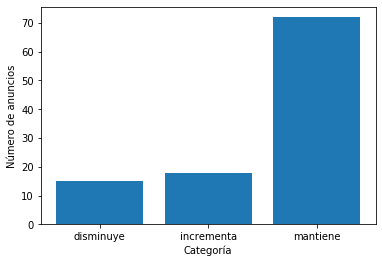

In [17]:
categoria_count=pub_df.groupby('categoria').count()
plt.bar(categoria_count.index.values, categoria_count['text_completo'])
plt.xlabel('Categoría')
plt.ylabel('Número de anuncios')
plt.show()

In [18]:
#quitamos cualquier otro elemento que pudiese hacer ruido como simbolos o números
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
#Generamos una matriz de términos del documento utilizando CountVectorizer de scikit-learn.
#Esta matriz está usando una sola palabra y el enfoque general son n-gramas.
cv = CountVectorizer(lowercase=True, ngram_range = (1,1),tokenizer = token.tokenize)
#Aplicamos la transformación a nuestro texto y convertimos cada anuncio en una DTM
text_counts= cv.fit_transform(pub_df['text_completo'])

In [19]:
#Para comprender el rendimiento del modelo, dividiremos el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba.
#Usamos la función train_test_split() basado en 3 parámetros, DTM, tamaño del test_set y random_state para seleccionar registros al azar.
#X_train: base de entrenamiento
#X_test: base de prueba
#ytrain: respuesta de entrenamiento
#y_test: respuesta de prueba
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, pub_df['categoria'], test_size=0.4, random_state=1)

In [20]:
#Realizaremos la Clasificación de Naives Bayes Multi-Nomial usando scikit-learn.
clf = MultinomialNB().fit(X_train, y_train)
#Basado en el entrenamiento predecimos las etiquetas de la base de prueba
predicted= clf.predict(X_test)
#Pintamos la precisión del modelo de los valores reales a los valores que predecimos con el modelo
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.7619047619047619


In [21]:
#Calculamos la mátriz de confusión para ver el detalle de la predicción
cm = confusion_matrix(y_test, predicted)
cm

array([[ 2,  0,  3],
       [ 0,  4,  2],
       [ 1,  4, 26]], dtype=int64)

La eficiencia de modelo sin realizar ningún tipo de inferencia sobre las palabras es mala.
Revisemos si existen caracterisicas en los anuncios que nos ayuden a mejorar la eficiencia del modelo.

$\textbf{6. Performance del algoritmo}$

In [22]:
# Calculamos las frecuencias en cada uno de los anuncios
#Lista vacia para guardar distribuciones de texto
lista_dist=[]
for k in range(0, n):
    lista_dist.append(FreqDist(pub_list2[k]['palabras']))

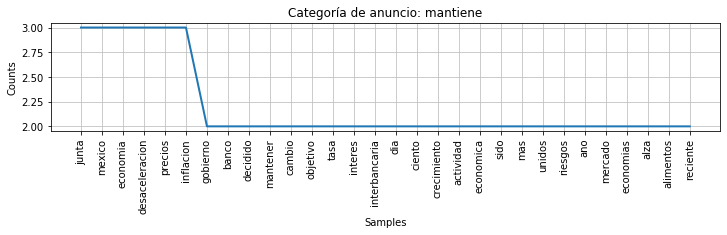

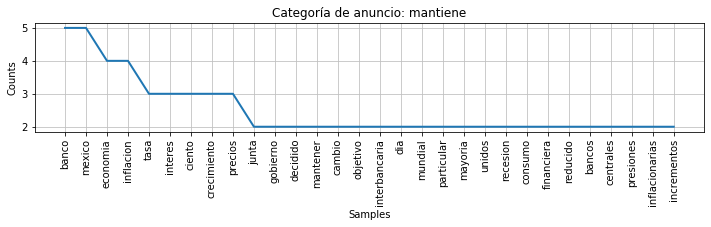

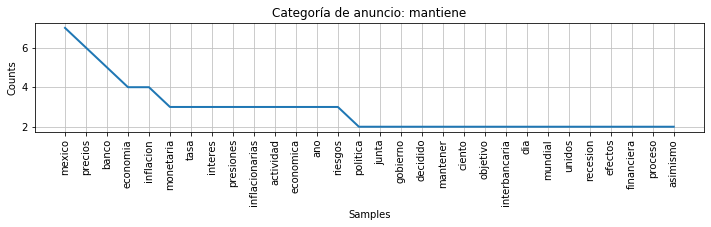

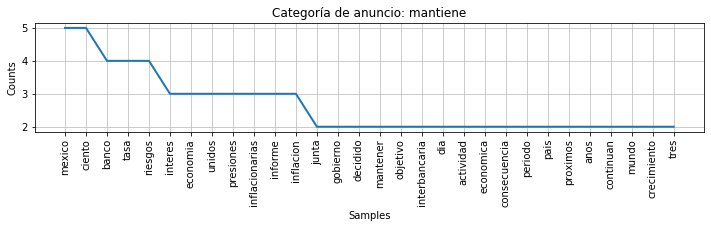

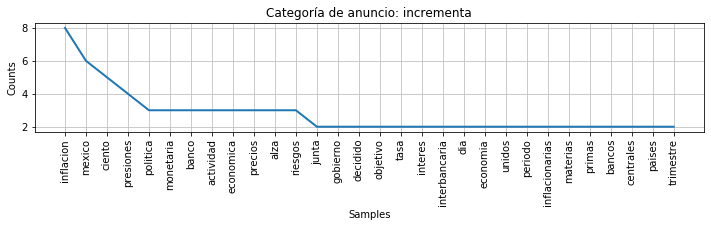

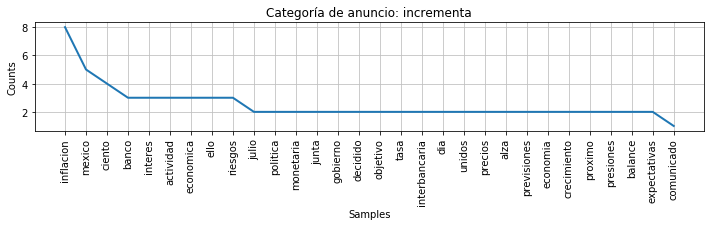

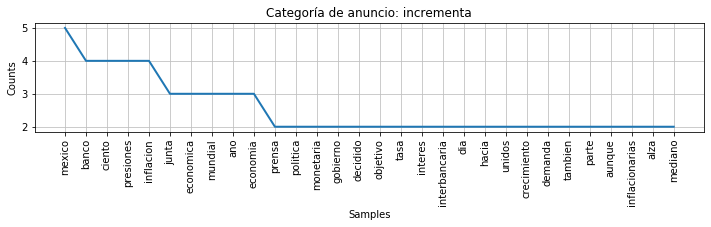

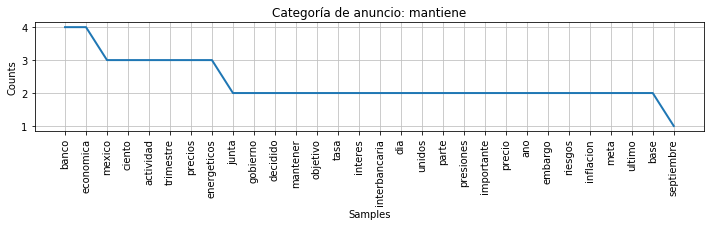

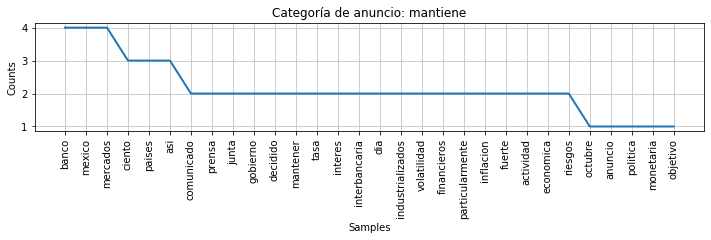

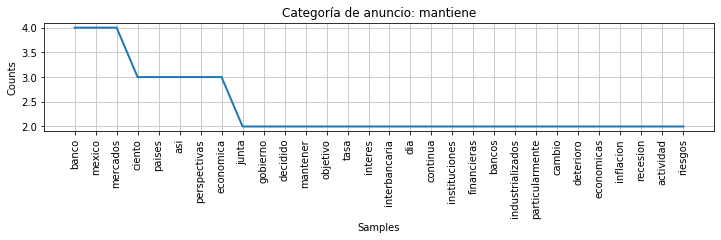

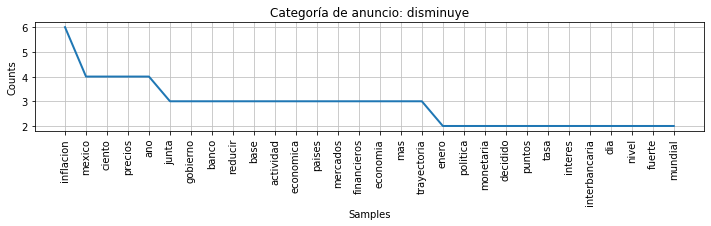

In [33]:
#Gráfica de frecuencias de palabras junto con la categoría del anuncio
plt.rcParams["figure.figsize"] = (12, 2)
for k in range(0,11):
        lista_dist[k].plot(30, cumulative=False, title=f'Categoría de anuncio: {lista_cat[k]}')

#De las gráficas (11) de frecuencia no podemos percatar que cada uno de los anuncios contemplan palabras que se intersectan en todos
#los anuncios, lo cual generar ruido al clasificador.

In [24]:
#Para el siguiente clasificador trabajaremos utilizando los párrafos que contengan información relevante y no generen ruido
#es decir los primeros de cada anuncio ya que son aquellos que contienen los puntos más importantes para su definición
#delimitados por la palabra 'interbancaria', refiriendose al comportamiento de la tasa.
for k in range(0, n):
    lista_text[k]=lista_text[k][0:lista_text[k].find("interbancaria")+len("interbancaria")].strip()

In [25]:
#lista vacia para lista de listas
pub_list3=[]
#Nuevas lista quedandonos solo con el primer parrafo
for k in range(0, n):
    pub_list3.append(diccionario(lista_fecha[k], lista_cat[k], lista_text[k], lista_text_palabras[k], lista_text_unicas[k]))


In [26]:
pub_df3=pd.DataFrame(pub_list3, columns=['date', 'categoria', 'text_completo'])

In [27]:
#quitamos cualquier otro elemento que pudiese hacer ruido como simbolos o números
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
#Generamos una matriz de términos del documento utilizando CountVectorizer de scikit-learn.
#Esta matriz está usando una sola palabra y el enfoque general son n-gramas.
cv = CountVectorizer(lowercase=True, ngram_range = (1,1),tokenizer = token.tokenize)
#Aplicamos la transformación a nuestro texto y convertimos cada anuncio en una DTM
text_counts= cv.fit_transform(pub_df3['text_completo'])

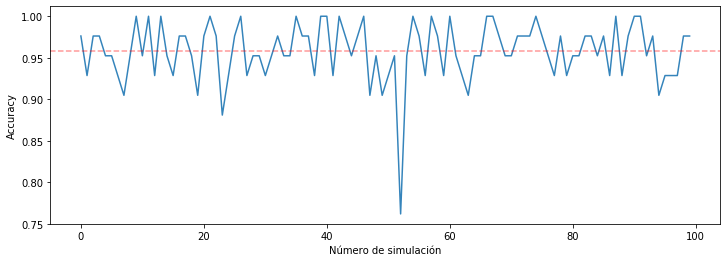

Promedio: 0.9578571428571431


In [28]:
#Definimos una función para realizar simulaciones
def prueba_NBM(simulaciones):
    import random
    numero_random=random.sample(range(1, 300), simulaciones)
    #Para comprender el rendimiento del modelo, dividiremos el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba.
    #Usamos la función train_test_split() basado en 3 parámetros, DTM, tamaño del test_set y random_state para seleccionar registros al azar.
    #X_train: base de entrenamiento
    #X_test: base de prueba
    #ytrain: respuesta de entrenamiento
    #y_test: respuesta de prueba
    #lista vacia para almacenar eficiencia 
    lista_ef=[]
    for numero in numero_random:
        X_train, X_test, y_train, y_test = train_test_split(text_counts, pub_df['categoria'], test_size=0.4, random_state=numero)
        #Realizaremos la Clasificación de Naives Bayes Multi-Nomial usando scikit-learn.
        clf = MultinomialNB().fit(X_train, y_train)
        #Basado en el entrenamiento predecimos las etiquetas de la base de prueba
        predicted= clf.predict(X_test)
        #Pintamos la precisión del modelo de los valores reales a los valores que predecimos con el modelo
        lista_ef.append(metrics.accuracy_score(y_test, predicted))
    return(lista_ef)

#vector de eficiencia de las simulaciones
plt.figure(figsize=(12,4))
simul=np.array(prueba_NBM(100))
plt.plot(simul, alpha=0.9)
plt.axhline(y=simul.mean(), color='r', linestyle='--', label='Promedio', alpha=0.4)
plt.xlabel('Número de simulación')
plt.ylabel('Accuracy')
plt.show()
print(f"Promedio: {simul.mean()}")

El modelo utilizando el primer párrafo tiene un buen performance. 
Solo habría que tener cuidado con los cambios de estructura en futuros anuncios de Banxico, ya que el modelo esa sobre estimado por la limitación de las medidas tomadas.